<a href="https://colab.research.google.com/github/muhammadali122/Human-Emotion-Detection/blob/main/Xception_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import datetime as dt
import glob
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from tensorflow.keras.applications import Xception
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Flatten
from keras.models import  Model
import tensorflow as tf

In [2]:
train_path = '/content/drive/MyDrive/FYP Project/dataset/train'
val_path = '/content/drive/MyDrive/FYP Project/dataset/test'

In [3]:
# re-size all the images to a size VGG-16 expects.
IMAGE_SIZE = [224, 224]

# Set the batch size
BATCH_SIZE = 20 
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 3 

In [4]:
import os
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

In [5]:
print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

Class --> ['NEGATIVE', 'NEUTRAL', 'POSITIVE'] 
 and the length is : 3


In [6]:
CLASSES

['NEGATIVE', 'NEUTRAL', 'POSITIVE']

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(val_path, 
                                                  target_size=IMAGE_SIZE, 
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

Found 1599 images belonging to 3 classes.
Found 533 images belonging to 3 classes.


In [8]:
# Initialize the base model
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(224,224, 3))

Compile The Model

In [9]:
base_model.compile(optimizer='adam', loss= tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

Summary

In [10]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [11]:
def extract_features(sample_count, datagen):
    start = dt.datetime.now()
    features =  np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count,3))
    generator = datagen
    i = 0
    for inputs_batch,labels_batch in generator:
        stop = dt.datetime.now()
        time = (stop - start).seconds
        print('\r',
              'Extracting features from batch', str(i+1), '/', len(datagen),
              '-- run time:', time,'seconds',
              end='')
        
        features_batch = base_model.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        
        if i * BATCH_SIZE >= sample_count:
            break
            
    print("\n")
    
    return features,labels

In [12]:
train_features, train_labels = extract_features(1599, train_generator)
test_features, test_labels = extract_features(533, test_generator)

 Extracting features from batch 80 / 80 -- run time: 34 seconds

 Extracting features from batch 27 / 27 -- run time: 142 seconds



In [14]:
flat_dim = 7 * 7 * 2048
train_features = np.reshape(train_features, (1599, flat_dim))
test_features = np.reshape(test_features, (533, flat_dim))

In [15]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [16]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=flat_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 51,382,275
Trainable params: 51,382,275
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(train_features, 
                    train_labels, 
                    epochs=30,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/30
72/72 [==============================] - 2s 19ms/step - loss: 2.5965 - acc: 0.7804 - val_loss: 0.8672 - val_acc: 0.8562 - lr: 0.0010
Epoch 2/30
72/72 [==============================] - 1s 16ms/step - loss: 0.5247 - acc: 0.8562 - val_loss: 0.3869 - val_acc: 0.9187 - lr: 0.0010
Epoch 3/30
72/72 [==============================] - 1s 16ms/step - loss: 0.2964 - acc: 0.8909 - val_loss: 0.3948 - val_acc: 0.8938 - lr: 0.0010
Epoch 4/30
72/72 [==============================] - 1s 17ms/step - loss: 0.2711 - acc: 0.8965 - val_loss: 0.3146 - val_acc: 0.9250 - lr: 0.0010
Epoch 5/30
72/72 [==============================] - 1s 16ms/step - loss: 0.2517 - acc: 0.8909 - val_loss: 0.4068 - val_acc: 0.9187 - lr: 0.0010
Epoch 6/30
72/72 [==============================] - 1s 17ms/step - loss: 0.2476 - acc: 0.8999 - val_loss: 0.3244 - val_acc: 0.9062 - lr: 0.0010
Epoch 7/30
72/72 [==============================] - 1s 16ms/step - loss: 0.2139 - acc: 0.9069 - val_loss: 0.4594 - val_acc: 0.9125 - lr:

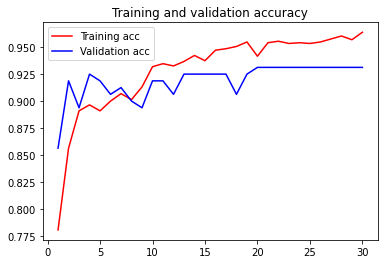

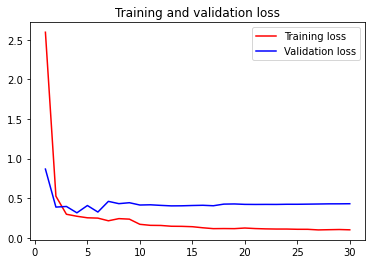

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [19]:
preds = model.predict(test_features)

In [20]:
# Change labels from one-hot encoded
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]

In [23]:
predictions

[0,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 2,


In [24]:
y_true

[0,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 2,


In [21]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

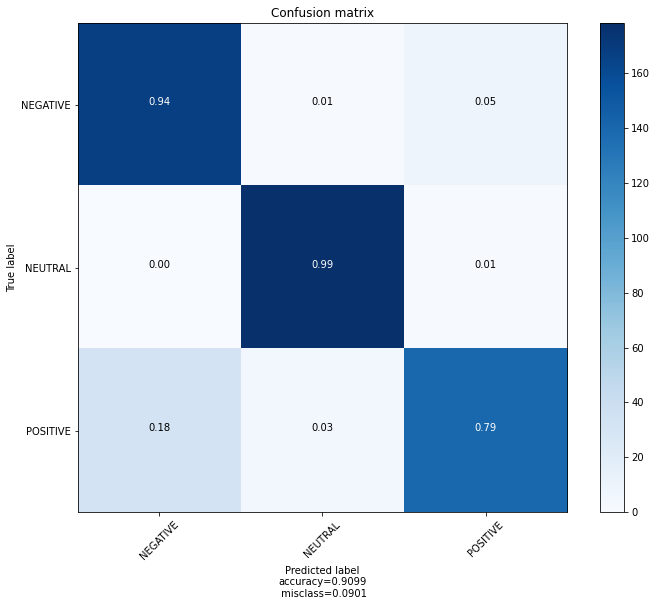

In [22]:
cm = confusion_matrix(y_pred=predictions, y_true=y_true)
plot_confusion_matrix(cm, normalize=True, target_names=CLASSES)